In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from scipy.stats import norm
from astropy.cosmology import FlatLambdaCDM

In [2]:
def isNaN(string):
    return string!=string

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

In [3]:
dat = pd.read_csv("VLA2018data/grdr7_Shen2011_8403col_lofar_first_vlass_nvssFF_info.csv")
dat.head()

,col1,Name,RA_1,Dec_1,SDSS_NAME,RA_2,DEC_2,REDSHIFT,TARGET_FLAG_TARGET,UNIFORM_TARGET,...,RA2000_1,DEC2000_1,Separation_1b,Dec+1,RA2000x,DEC2000x,NVSSblank (Jy/beam),RA2000_2,DEC2000_2,Separation
0,5150,SDSSJ133014.11+344621.4,202.558796,34.772623,133014.11+344621.4,202.558792,34.772621,1.8699,1048579.0,1.0,...,202.558792,34.772611,0.044677,35.772623,13:30:14.11,+35:46:21.4,0.00071,202.558792,35.772611,0.0428
1,2965,SDSSJ115350.87+564413.7,178.461970,56.737165,115350.87+564413.7,178.461975,56.737164,1.8987,2.0,1.0,...,178.461958,56.737167,0.023805,57.737165,11:53:50.87,+57:44:13.8,0.00008,178.461958,57.737167,0.0060
2,2281,SDSSJ212450.27+010157.0,321.209483,1.032524,212450.27+010157.0,321.209473,1.032524,1.7359,1048578.0,1.0,...,321.209500,1.032528,0.062683,2.032524,21:24:50.28,+02:01:57.1,0.00001,321.209500,2.032528,0.0136
3,2282,SDSSJ212359.10+002845.0,320.996273,0.479194,212359.10+002845.0,320.996277,0.479194,1.8577,1048579.0,1.0,...,320.996292,0.479194,0.067217,1.479194,21:23:59.11,+01:28:45.1,0.00060,320.996292,1.479194,0.0016
4,3709,SDSSJ103924.81+103201.1,159.853404,10.533655,103924.81+103201.1,159.853409,10.533655,1.8904,2.0,1.0,...,159.853417,10.533667,0.061432,11.533655,10:39:24.82,+11:32:01.2,-0.00052,159.853417,11.533667,0.0420


In [4]:
#for some reasion, 1003 are not in the Rankine+20 CIV catalog
blank_sky = dat["NVSSblank (Jy/beam)"].values*1e3 ; blank_sky = blank_sky[~np.isnan(blank_sky)] #in mJy/beam
CIVdist = dat["CIV_Distance"].values
dat = dat[~isNaN(CIVdist)]

In [5]:
len(blank_sky)

1000

In [6]:
flux = dat["NVSSff (Jy/beam"].values*1e3 #in mJy/beam
CIVdist = dat["CIV_Distance"].values

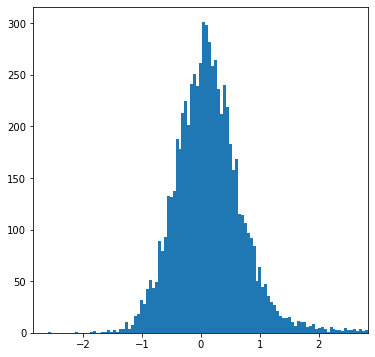

In [7]:
fig = plt.figure(figsize=(6,6))
plt.hist(flux, bins=np.linspace(-5, 5, 200))
plt.xlim(min(flux), -min(flux))
plt.show()

In [8]:
CIVlow  = (CIVdist<0.4875)
CIVhigh = (CIVdist>0.74)
CIVlow.sum(), CIVhigh.sum()

(1007, 1009)

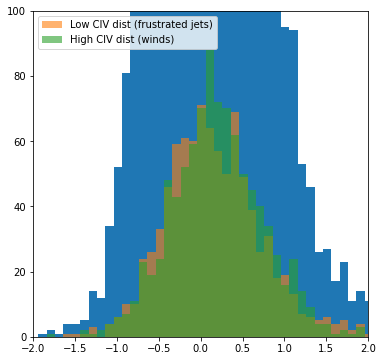

In [9]:
bins = np.arange(min(flux), -min(flux), 0.1)

fig = plt.figure(figsize=(6,6))
plt.hist(flux, bins=bins)
#plt.hist(blank_sky, bins=bins, alpha=0.3, label="Blank Sky")
plt.hist(flux[CIVlow], bins=bins, alpha=0.6, label="Low CIV dist (frustrated jets)")
plt.hist(flux[CIVhigh], bins=bins, alpha=0.6, label="High CIV dist (winds)")
plt.xlim(-2, 2)
plt.ylim(0,100)
plt.legend(loc="best")
plt.show()

In [14]:
#sigma clip distribution and fit
flux_clip     = sigma_clip(flux,sigma_lower=3,sigma_upper=3,maxiters=10,masked=False)
fluxlow_clip  = sigma_clip(flux[CIVlow],sigma_lower=3,sigma_upper=3,maxiters=10,masked=False)
fluxhigh_clip = sigma_clip(flux[CIVhigh],sigma_lower=3,sigma_upper=3,maxiters=10,masked=False)
blank_clip    = sigma_clip(blank_sky,sigma_lower=3,sigma_upper=3,maxiters=10,masked=False)

In [15]:
len(flux_clip)

6791

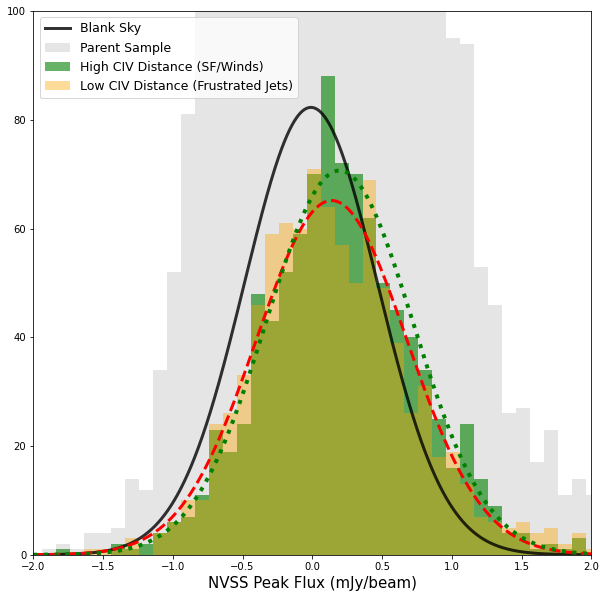

In [41]:
bins_clip = np.arange(min(flux_clip), max(flux_clip), 0.1)
fig,ax = plt.subplots(1,1,figsize=(10,10))
#plt.hist(blank_sky, color="k", bins=bins)
plt.hist(flux, bins=bins, color='grey', alpha=0.2, label="Parent Sample")
plt.hist(flux[CIVhigh], bins=bins, color='green', alpha=0.6, label="High CIV Distance (SF/Winds)")
plt.hist(flux[CIVlow], bins=bins, color='orange', alpha=0.4, label="Low CIV Distance (Frustrated Jets)")

testbins = np.arange(-3, 3, 0.001) #these bins look nicer for fits
(mu_blank, sigma_blank) = norm.fit(blank_clip)
median_blank = np.median(blank_clip)
yblank = norm.pdf(testbins, mu_blank, sigma_blank)
yblank_true = (yblank*len(blank_clip)*0.1) #get rid of normalization - 0.1 is bin width
plt.plot(testbins, yblank_true, 'k-', linewidth=3, label="Blank Sky", alpha=0.8)

# This gives the true median and sigma
(mu_low, sigma_low) = norm.fit(fluxlow_clip)
median_low = np.median(fluxlow_clip)
#PDF of the clipped distribution
ylow = norm.pdf(testbins, mu_low, sigma_low)
ylow_true = (ylow*len(fluxlow_clip)*0.1) #get rid of normalization - 0.1 is bin width
plt.plot(testbins, ylow_true, 'r--', linewidth=3)

(mu_high, sigma_high) = norm.fit(fluxhigh_clip)
median_high = np.median(fluxhigh_clip)
yhigh = norm.pdf(testbins, mu_high, sigma_high)
yhigh_true = (yhigh*len(fluxhigh_clip)*0.1) #get rid of normalization - 0.1 is bin width
plt.plot(testbins, yhigh_true, 'g:', linewidth=4)

plt.xlabel("NVSS Peak Flux (mJy/beam)", fontsize=15)
plt.xlim(-2, 2)
plt.ylim(0,100)
plt.legend(loc="best", prop={"size":12.5})
plt.show()

In [20]:
np.mean(blank_clip)

-0.009837563451776655

Blank sky has zero mean flux, as expected.

In [176]:
mu_low, sigma_low, mu_high, sigma_high, mu_blank, sigma_blank

(0.13826530612244897,
 0.5399108076150678,
 0.19458646616541353,
 0.5254795935248437,
 0.07087,
 1.1216364576367872)

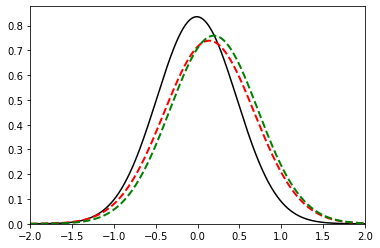

In [48]:
plt.plot(testbins, yblank, "k-")
plt.plot(testbins, ylow, 'r--', linewidth=2)
plt.plot(testbins, yhigh, 'g--', linewidth=2)
plt.xlim(-2,2)
plt.ylim(0,None)
plt.show()

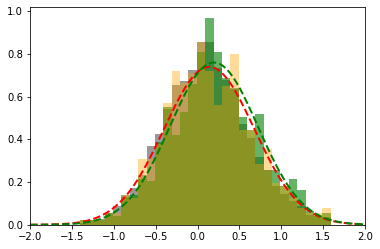

In [51]:
plt.hist(flux_clip, bins=bins_clip, color='grey', alpha=0.8, label="Parent Sample", density=True)
plt.hist(fluxhigh_clip, bins=bins_clip, color='green', alpha=0.6, label="High CIV Distance", density=True)
plt.hist(fluxlow_clip, bins=bins_clip, color='orange', alpha=0.4, label="Low CIV Distance", density=True)
plt.plot(testbins, ylow, 'r--', linewidth=2)
plt.plot(testbins, yhigh, 'g--', linewidth=2)
plt.xlim(-2,2)
plt.show()

Is offset meaningful?..maybe?

In any case, this is consistent with what we originally thought going into this: low CIV distance (orange/red) maybe has weak jets and thus has a "bump" lower flux density than high CIV distance (green), which has more "consistent" (rather than stochastic) radio emission.

What are the corresponding radio luminosities?

In [42]:
radluminosity(3., 1.4, mu_low*1.e3, -0.7, z=2), radluminosity(3., 1.4, mu_high*1.e3, -0.7, z=2)

(24.226762198333464, 24.37516160984511)

About 0.15dex offset in radio luminosity between the two.

---

Try to somehow illustrate this in the CIV plot

In [59]:
def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1638*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label="VLA Detections")

In [55]:
vla = pd.read_csv("VLA2018data/SpringFinalFigs_moreParams.csv")
vla.head()

,SDSS_NAME_1,RA_1,DEC_1,REDSHIFT,PLATE,FIBER,MJD,TARGET_FLAG_TARGET_1,NSPECOBS_1,UNIFORM_TARGET_1,...,ICA_CIV_EQW_new2021,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_BLUESHIFT_SCALED,CIV_EQW_SCALED,CIVBestfit_Index,L3GHz [W/Hz],CIV_DIST_021721,CIV_DIST_041921,CIV_DIST_FINAL
0,001342.45-002412.6,3.426880,-0.403514,1.6409,389,274,51795,68,1,0,...,35.900650,1728.413701,3.486256,0.722760,-0.879689,275801.0,24.469498,3.506315,2.792875,0.662801
1,014023.83+141151.7,25.099302,14.197709,1.6544,426,514,51882,4,1,0,...,33.912371,414.691980,2.589969,-0.319656,-0.943523,238121.0,24.841584,2.618358,2.230519,0.542545
2,014658.21-091505.2,26.742563,-9.251470,1.6516,664,543,52174,1048580,1,0,...,34.648832,646.782974,2.704445,-0.134167,-0.920323,244881.0,23.606351,2.734290,2.304035,0.560694
3,015720.27-093809.1,29.334463,-9.635872,1.6494,666,298,52149,4,1,0,...,43.720855,796.239578,2.635625,-0.014596,-0.653142,240918.0,23.761645,2.685961,2.164442,0.536344
4,081656.84+492438.1,124.236839,49.410603,1.6464,440,552,51885,1048580,2,0,...,36.524054,1490.190560,3.289717,0.534205,-0.861619,269740.0,23.545828,3.312861,2.652129,0.636308


In [60]:
S3 = vla["int_flux"].values
z_vla = vla["redshift_1"].values
L3 = radluminosity(3., 3., S3, -0.7, z_vla)
L14_vla = radluminosity(1.4, 3., S3, -0.7, z_vla)
det_vla = vla["detection"].values
F_vla = vla['FIRST'].values.astype("int")
D_vla = det_vla+F_vla
ew_vla = vla["ICA_CIV_EQW_new2021"].values
voff_vla = vla["ICA_CIV_BLUESHIFT"].values
Mi_vla = vla["MI_Z2_1"].values

#Star formation rates from Harris/Yun
avgSFR_vla = (SFR_Mi(Mi_vla) + SFR_eqw(ew_vla)) / 2.
SFRL14_vla = SFR_L14(L14_vla)

Now lofar

In [73]:
lofar = pd.read_csv("VLA2018data/LOFAR_from8403colorselected_all388_CIV.csv")
lofar.sort_values("name", inplace=True)
lofar.head()

,SDSS_NAME_1a,RA_1a,DEC_1a,REDSHIFT,PLATE_1a,FIBER_1a,MJD_1a,TARGET_FLAG_TARGET,NSPECOBS,UNIFORM_TARGET,...,CIV_DIST_FINAL,RA_1,Dec_1,Peak_flux,E_Peak_flux,E_Peak_flux_tot,Total_flux,E_Total_flux,E_Total_flux_tot,Separation
0,104446.00+521742.8,161.191681,52.295242,1.7513,1010,182,52649,3,1,1,...,0.519443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104547.58+551853.8,161.448257,55.314972,1.8896,906,462,52368,1048578,1,1,...,0.495808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104718.64+541917.8,161.827698,54.321629,1.8288,906,55,52368,3145739,1,1,...,0.540458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104829.97+550819.0,162.124893,55.138630,2.0671,906,518,52368,1048578,1,1,...,0.772250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104852.00+530747.2,162.216675,53.129780,1.6792,1010,509,52649,1048578,1,1,...,0.539767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
det_lofar = ~np.isnan(lofar["Peak_flux"].values)
S144 = 210.*np.ones(len(lofar)) #initialize all objects to non-detections
S144[det_lofar] = lofar["Total_flux"].values[det_lofar] * 1.e3
z_lofar = lofar["z_paul"].values
L3_lofar = radluminosity(3., 0.144, S144, -0.7, z_lofar)
L14_lofar = radluminosity(1.4, 0.144, S144, -0.7, z_lofar)
ew_lofar = lofar["CIV_EW"].values
voff_lofar = lofar["CIV_blue"].values
Mi_lofar = lofar["MI_Z2"].values

#Star formation rates from Harris/Yun
avgSFR_lof = (SFR_Mi(Mi_lofar) + SFR_eqw(ew_lofar)) / 2.
SFRL14_lof = SFR_L14(L14_lofar)

In [75]:
vla_dist = vla[["CIV_DIST_FINAL"]].values.flatten() 
lof_dist = lofar[["CIV_DIST_FINAL"]].values.flatten()

Now determine SFR from Harris+16 and Yun+01

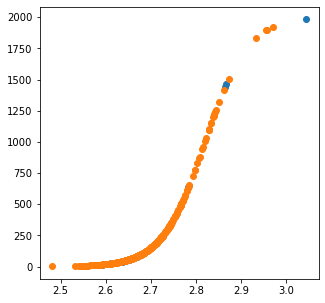

In [76]:
#Star formation rates from Harris/Yun

#The standard size scaling for these plots -
#Determination of this scaling happened in Trevor's version of "CIV_plot_GTR_fixed.ipynb"
#sent to GTR and AEK through the e-mail thread "VLA Paper" on 9/3/2020 at 5:05 PM

plt.figure(figsize=(5,5))

A = 0. #lower asymptote
K = 2000. #upper asymptote
B = 21. #growth rate -- the bigger this is, the quicker you reach the upper asymptote
nu = 1. #affects where the max growth occurs
Q = 1199. #bigger Q returns a smaller starting size 

sharris_vla = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR_lof)))))**(1/nu)) for i in np.log10(avgSFR_vla)])
syun_vla = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(SFRL14_vla)))))**(1/nu)) for i in np.log10(SFRL14_vla)])

sharris_lof = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR_lof)))))**(1/nu)) for i in np.log10(avgSFR_lof)])
syun_lof = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(SFRL14_lof)))))**(1/nu)) for i in np.log10(SFRL14_lof)])

plt.scatter(np.log10(avgSFR_vla), sharris_vla)
plt.scatter(np.log10(avgSFR_lof), sharris_lof)

In [77]:
first = pd.read_csv("VLA2018data/lofar_first_quasars.csv")

In [78]:
#Want a mask that picks out FIRST detections from our LOFAR sources
lof = lofar["name"].values
fir = first["name"].values
lof.sort(), fir.sort()
lofar_1st = np.array([])

for i in range(len(lof)):
    if (lof[i]==fir).any():
        lofar_1st = np.append(lofar_1st, True)
    else:
        lofar_1st = np.append(lofar_1st, False)

first_lofar = (lofar_1st==1.)

In [80]:
#Get dashed lines to draw above - see CIVPlot_wLOFAR_final_finalCIVdist.ipynb
CIV_0p50 = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/const_civdist_arrs/CIVdist_eq_0.50.npy")
m_50, b_50 = np.polyfit(10.**CIV_0p50[:,1], CIV_0p50[:,0], 1)
x_50 = np.arange(37, 69, 1)

CIV_0p75 = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/const_civdist_arrs/CIVdist_eq_0.75.npy")
m_75, b_75 = np.polyfit(10.**CIV_0p75[:,1], CIV_0p75[:,0], 1)
x_75 = np.arange(2, 40, 1)

y_50 = m_75*x_50 + b_50
y_75 = m_50*x_75 + b_75

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Trevor1/Desktop/git/CIV_Distance/data/const_civdist_arrs/CIVdist_eq_0.50.npy'